In [1]:
import os
import glob
import sys
from tqdm import tqdm 
from itertools import groupby
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/ubuntu/github/Mask_RCNN/")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_DIR = os.path.join(MODEL_DIR, "coco20190530T1419")
COCO_MODEL_PATH = os.path.join(COCO_MODEL_DIR, "mask_rcnn_coco_0035.h5")

import tensorflow as tf
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(ROOT_DIR+"samples/imaterialist") 
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import coco

Using TensorFlow backend.


In [2]:
IMAGE_DIR = '/home/ubuntu/efs/kaggle/imaterialist/test/'

testImages = glob.glob(IMAGE_DIR+'*.jpg')

In [3]:
config = coco.CocoConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

dataset = coco.CocoDataset()
COCO_DIR = "/home/ubuntu/efs/kaggle/imaterialist/" 
dataset.load_coco(COCO_DIR, "val")
dataset.prepare()

loading annotations into memory...
Done (t=4.97s)
creating index...
index created!


In [4]:
DEVICE = "/gpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True) 


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 35


In [31]:
img = Image.open(testImages[1])
img = np.array(img.resize((512,512)))
results = model.detect([img], verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


In [34]:
dataset.class_names[24]

'shoe'

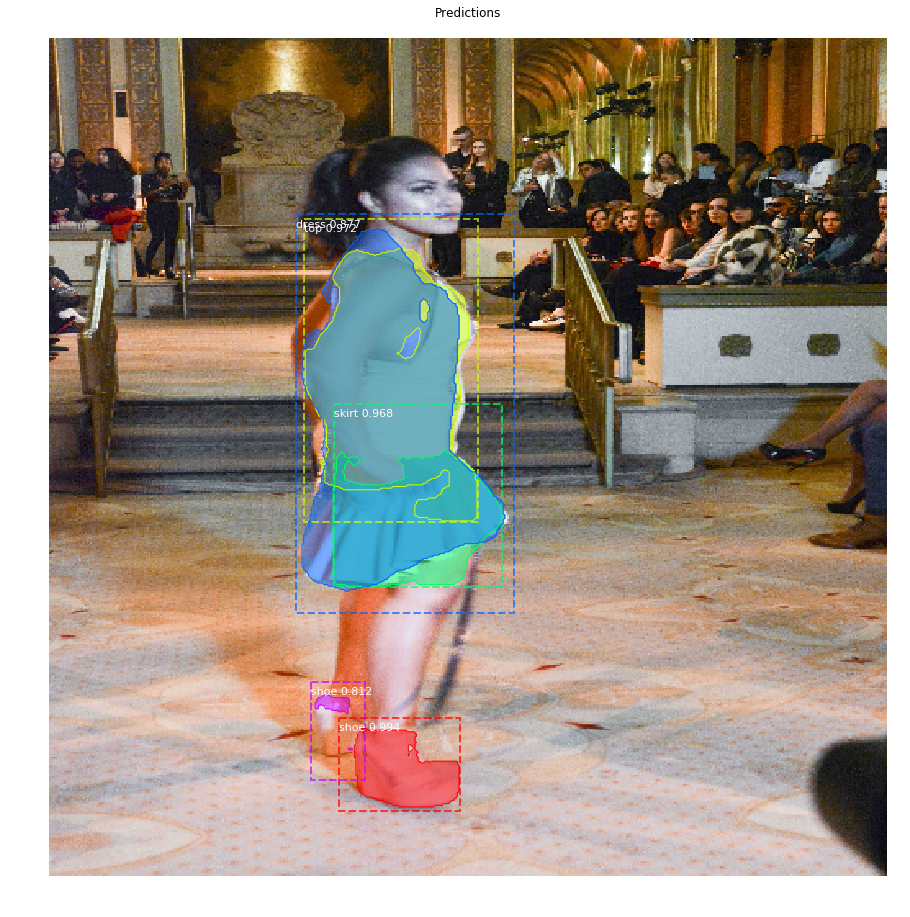

In [32]:
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")


In [39]:
def EncodeMask(mask):
    '''
        Transpose mask, then encode it
    '''
    x = np.ravel(mask.transpose())

    group = [(k,len(list(g))) for k, g in groupby(x)]
    encode = ""
    index = 1
    for value, length in group:
        if value != 0:
            encode+= "%s %s "%(index, length)
        index+=length
    return encode  
                
resultList = []

for fname in tqdm(testImages):
    img = Image.open(fname)
    img = np.array(img.resize((512,512)))
    results = model.detect([img], verbose=0)[0]
    basename = os.path.basename(fname)
    if len(results['class_ids'])>0:
        masks = {}
        for i, classId in enumerate(results['class_ids']):
            if classId not in masks:
                masks[classId] = results['masks'][:,:,i]
            else:
                masks[classId] = np.logical_or(masks[classId], results['masks'][:,:,i])
        
        for classId, mask in masks.items():
            encodedPixel = EncodeMask(mask)
            resultList.append([basename, encodedPixel,  classId-1]) 
    else:
        resultList.append([basename, "1 0", 45])
submissionDf=pd.DataFrame(resultList, columns=["ImageId", "EncodedPixels", "ClassId"])

submissionDf.to_csv("submission.csv", index=False) 
    
assert(len(list(submissionDf.ImageId.unique()))==3200)

submissionDf.head(10)    

100%|██████████| 3200/3200 [11:11<00:00,  5.16it/s]


,ImageId,EncodedPixels,ClassId
0,bea6c37663ba0eec0869236de1b1a430.jpg,45934 87 46438 97 46949 99 47459 102 47970 104...,10
1,bea6c37663ba0eec0869236de1b1a430.jpg,95896 2 96407 5 96918 5 97430 5 97941 6 98453 ...,36
2,bea6c37663ba0eec0869236de1b1a430.jpg,49507 100 50015 108 50524 113 51035 116 51546 ...,8
3,bea6c37663ba0eec0869236de1b1a430.jpg,110227 1 110739 1 111251 1 111763 1 112275 1 1...,33
4,f514d2cbb63a5f19edd12218d3a9d311.jpg,83863 4 84373 6 84884 5 85396 4 85907 6 86419 ...,23
5,f514d2cbb63a5f19edd12218d3a9d311.jpg,80576 22 81087 26 81599 28 82111 30 82623 32 8...,1
6,f514d2cbb63a5f19edd12218d3a9d311.jpg,89364 56 89867 67 90369 78 90880 79 91391 80 9...,8
7,f514d2cbb63a5f19edd12218d3a9d311.jpg,79552 17 79670 14 80060 25 80176 22 80569 32 8...,10
8,aba090c2aa6751db3ef7d97b2bcc23c7.jpg,93111 3 93622 6 94132 8 94642 11 95154 11 9566...,23
9,aba090c2aa6751db3ef7d97b2bcc23c7.jpg,96364 1 96874 3 97386 4 97897 5 98409 5 98920 ...,33


In [40]:
!kaggle competitions  submit imaterialist-fashion-2019-FGVC6 -f submission.csv -m "mask_rcnn_coco_0035.h5 loss=0.32"

100%|██████████████████████████████████████| 20.4M/20.4M [00:07<00:00, 3.06MB/s]
Successfully submitted to iMaterialist (Fashion) 2019 at FGVC6 